# Great Fake Painter

Fake Painter はどんなサイズの画像でも224x224にリサイズして処理していましたが，もっと大きな絵を描かせてみたいな，という要望に応えてみました．

動作環境
- Windows, MacOS, Linux で動作確認済み。いずれも Anaconda
- chainer 2.0
- python3.6 （3.5でもよい）
- opencv 3.2 (3.0でもよい。２でもよいかも） PILだけでも書けると思うが、本人が PIL より慣れてるためちょっとだけ使った。 

縦も横も200の倍数＋224でもっとも画像サイズに近いサイズに画像をリサイズし，224×224のブロック単位で処理します．
単純に分割処理すると境界がくっきりと目立ってしまって連続性がなくなるので，隣のブロックとは24ピクセル分重ねることにしました．

In [1]:
import chainer.functions as F
import chainer
from chainer.links import VGG16Layers
from chainer.links.model.vision.vgg import prepare as VGGprepare
from chainer import Variable, optimizers

import numpy as np
import PIL.Image
from PIL import ImageFilter
from io import BytesIO
import urllib.request
import cv2
import sys

#from IPython.html.widgets import FloatProgress
from ipywidgets import FloatProgress
from IPython.display import clear_output, Image, display

mean = [103.939, 116.779, 123.68]   # BGR

In [2]:
# 基本入出力関数

# url を指定して画像を読み込み
def url2img(url):
    url_response = urllib.request.urlopen(url)
    img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
    img = cv2.imdecode(img_array, -1)
    img =PIL.Image.fromarray(img[:, :, ::-1].copy())
    return img

# ファイルまたはウェブ上のファイルを読み込み
def getImage(filename):
        if filename[:4] == "http":
            img = url2img(filename)
        else:
            img = PIL.Image.open(filename)
        return img

# numpy画像の表示
def showarray(a, fmt='jpeg'):  # 
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

# blob データを PIL 画像に変換
def blob2img(blob, mean=mean):
    blob = (np.dstack(blob)+ mean)[:,:,::-1]   # BGR 2 RGB
    return PIL.Image.fromarray(np.uint8(np.clip(blob,0,255)))

# blob データを画像として保存
def save_image(blobimg, it, fn = "frames",mean =mean):
    image = blob2img(blobimg, mean=mean)
    image.save(fn+"/im_%05d.png"%it)
    return image

# チャネル間の相関行列
def ch_corr_matrix(ld):
    # 0次元目はバッチ数
    ch = ld.shape[1] # チャネル数
    size = ld[0][0].size  # チャネルあたりのデータ数
    cmatrix = F.reshape(ld, (ch,size)) # チャネルごとに１次元化した ch x size の配列を作る
    matrix = F.matmul(cmatrix, cmatrix,transb=True) / np.float32(ch*size) # 相関行列
    return matrix

In [3]:
# layers_for_orig = ["conv4_1", "conv4_2", "conv4_3", "pool4"]
# layers_for_style =["conv1_1", "conv1_2", "pool1", "conv2_1", "conv2_2", "pool2", "conv3_1", "conv3_2", "conv3_3v3","pool3"]

CROPSIZE = (3,224,224)

# Fake Painter -- VGG16Layer の拡張クラス
class FakePainter(VGG16Layers):
    def __init__(self):
        super(FakePainter, self).__init__()
        with self.init_scope():
            self.autopic = chainer.links.Parameter(self.genpic())
            self.opic = np.zeros(CROPSIZE ,dtype='f')
            self.spic = np.zeros(CROPSIZE ,dtype='f')
    
    def __call__(self, vimg, layers=['prob']):
         return self.myextract(vimg, layers=layers)
            
    def myextract(self,vimg, layers=['prob']):
        if vimg.data.ndim == 3:
            vimg = F.reshape(vimg,(1,3,224,224))
        return super(FakePainter,self).__call__(vimg,layers=layers)
    
    def genpic(self):
        genpic = np.random.uniform(-20,20,CROPSIZE ).astype(np.float32)
        return genpic
    
    def setpic(self, nimg):
        self.autopic.W.data = nimg
 
    def show(self,mode=0):
        if mode == 1 :
           img = blob2img(self.opic)
        elif mode == 2 :
           img = blob2img(self.spic)
        else :
           img = blob2img(self.autopic.data)  
        return img
        
    # VGGprepare を使って画像をVGG16用に変換
    def setImage(self,img, withsmooth=False):
        nimg = VGGprepare(img)
        if withsmooth:
            mag = min(img.size)/224
            self.smimg = img.filter(ImageFilter.GaussianBlur(3*mag))# ぼかしたイメージ 
            nsmimg = VGGprepare(self.smimg)
            return nimg, nsmimg
        else:
            return nimg
        
    # autopic をもとに前向き伝搬
    def autoforward(self,layers=['prob']):
        h = self.myextract(self.autopic, layers=layers)
        return h
    
    # 処理対象画像をセット
    def setOimage(self,img, layers=['vpool4']):
        self.opic, smpic =  self.setImage(img, withsmooth=True)
        vimg = Variable(self.opic)
        h = self.myextract(vimg,layers=layers)  # 対象画像の特徴情報
        self.Ofeatures = h
        self.vsmimg = smpic
        
    # スタイル画像をセット
    def setSimage(self,img,layers=['conv4_1']):
        self.spic =  self.setImage(img)
        vimg = Variable(self.spic)
        h = self.myextract(vimg,layers=layers)
        cor = {}
        for l in h.keys():
            cor.update({l:ch_corr_matrix(h[l])})
        self.Sfeatures = h
        self.Scorr = cor

################ 
nn=FakePainter()    ##  <- これが主役
################

In [4]:
# 基本となる 224x224 サイズの画像の描画
def generate224(nn,oimg,styleimg,itr,l1,l2,dlosslimit):
        global progress2        
        nn.setOimage(oimg,l1)
        nn.setSimage(styleimg,l2)
        
        # パラメータ
        oldloss = np.array([1e+30,1e+30,1e+30,1e+30]) # 
        tolerance = 2 # この回数以上 loss が前より上昇したらあきらめる
        upcount = 0 # loss が連続上昇した回数のカウンタ

        # train mode
        chainer.config.train=False
        chainer.config.enable_backprop=True

        optimizer = optimizers.Adam(alpha=lr, beta1=0.5)
        optimizer.setup(nn.autopic)

        # oldx = nn.autopic.W  # 　前回の　x の値の初期値     myoptimize を使う場合はこの2行のコメントをはずす
        # oldx.grad = np.zeros_like(oldx.data)  # grad はゼロにセット

        for times  in range (itr):
            nn.cleargrads()  # 微係数データを初期化                
            loss = Variable(np.zeros(()).astype(np.float32))
            loss1 = Variable(np.zeros(()).astype(np.float32))  # 入力画像との自乗誤差
            loss2 = Variable(np.zeros(()).astype(np.float32))  # スタイル画像とのチャネル相関の自乗誤差

            #  l1での現画像と入力画像の誤差を求める
            x = nn.autopic.W
            # 前向き伝搬して指定した層のデータを取得
            efs = nn.myextract(x,layers=list(set(l1+l2)))
            
            for key in l1:
                ef = efs[key]
                of = nn.Ofeatures[key].data  # 先に保存してある対象画像の指定層データ
                loss1 += F.mean_squared_error(ef,of)   # 距離を誤差とする
 
            #  l2での現画像とスタイル画像のチャネル相関誤差を求める
            for key in l2:
                ef = efs[key]
                of = Variable(nn.Sfeatures[key].data) # 先に保存してあるスタイル画像の指定データ
                ecm = ch_corr_matrix(ef)   # チャネル相関マトリクス
                ocm = nn.Scorr[key].data  # 先に保存してあるスタイル画像のチャネル相関マトリクス
                loss2 += F.mean_squared_error(ecm, ocm)  # マトリクス間の自乗誤差

            loss3 = F.mean_squared_error(x, Variable(nn.vsmimg))    # 元の画像におおまかに近づけるための項
           
            loss = rr1*loss1+rr2*loss2+(1-rr1-rr2)*loss3
                        
            loss.backward()

            xgrad = x.grad   #　 loss に対する入力の寄与を保存
            nn.cleargrads()  # nn 全体の微分データをクリア
            x.grad = xgrad

            # chainer のオプティマイザーを使わない場合はこの4行のコメントを外す
            # def myoptimize(oldvimg, vimg, alpha=0.1, beta=0.5):
            #    vimg.data -= alpha * ( vimg.grad + beta * oldvimg.grad)
            # return vimg
            # x = myoptimize(oldx, x, alpha = lr, beta = 0.5)

            # chainer のオプティマイザー
            optimizer.update()
           
            nn.autopic.W = x   # 自動生成画像を更新データで上書き
            
            # 0+xxx としているのは，そうしないと formet が型エラーを吐くから
            tl, tl1,tl2,tl3 = 0+loss.data, 0+rr1*loss1.data, 0+rr2*loss2.data, 0+(1-rr1-rr2)*loss3.data
            if times > 0:
                sys.stdout.write("\r{:5d} {:.5f}  = {:.5f} +{:.5f}+ {:.5f}  ( {:.5f}  {:.5f}  {:.5f} ({}))".format(times, tl, tl1, tl2, tl3, tl1-oldloss[1], tl2-oldloss[2], tl3-oldloss[3],upcount))
                sys.stdout.flush()
                
            progress2.value = times
            
            # oldx = x    #  1回前の x を記憶  myoptimize を使う場合はコメントを外す
            
            if   loss.data < dlosslimit:
                print("評価基準を超えた")
                break
            if   loss.data > oldloss[0]:
                upcount = upcount + 1
            else:
                upcount = 0
            if upcount > tolerance:
                print("ロスが増えつづけているので停止")
                break
                
            oldloss = (tl, tl1,tl2,tl3)   
 
        return blob2img(nn.autopic.W.data,mean=mean),loss.data
            


In [5]:
# 描画メソッド
def generate3(nn,oimg,style, steps=1,itr=100,cont=False,l1=['conv4_3','pool4'], \
              l2=['conv4_1','conv4_2','conv4_3','pool4'],\
             fn="frames", dlosslimit = 100):
    # nn: ネットワーク、oimg：対象画像名, style：スタイル画像, cont: 前回の続き、\
    # itr:繰り返し回数, l1: oimgから取り出す階層、l2:style から取り出す階層, 
    # fn: 出力フォルダ名, 
    # dlossliit: loss がこれ以上下がったら終わる 

    # 描画対象画像の読み込み
    if type(oimg) == PIL.Image.Image: # 原画像
        Oimg = oimg
    else:
        Oimg = getImage(oimg)  
    (width,height) = Oimg.size   # 原画像のサイズ
    # スタイル画像をセット
    if type(style) == PIL.Image.Image: # 
        styleimg = style 
    else:
        styleimg = getImage(style)

    # Progress bar
    global progress0,progress1,progress2
    progress0 = FloatProgress(min=0, max=steps-1)
    progress1 = FloatProgress(min=0, max=(int((width-223)/200)+1)*(int((height-223)/200)+1))    
    progress2 = FloatProgress(min=0, max=itr-1)
    display(progress0)
    display(progress1)
    display(progress2)

    bimg = Oimg.copy().filter(ImageFilter.GaussianBlur(25))
    nn.autopic.W.data = VGGprepare(bimg) # autopic にぼかした画像をセット
    
    # 画像全体を使って１サイクル描画を実行する．これを拡大分割したものを各ブロックの種とする
    Firstimg,_= generate224(nn,Oimg,styleimg,itr=itr,l1=l1, l2=l2, \
                                  dlosslimit=dlosslimit)
     
    # 200の倍数＋224で画像より小さくかつもっとも画像サイズに近いサイズを計算
    width1 = (int((width-224)/200))*200+224 
    height1 = (int((height-224)/200))*200+224  
    Oimg = Oimg.resize(np.array((width1,height1))) # 原画像のサイズをフィットさせる
    # ぼかしのために枠をつける
    Bimg = PIL.Image.new('RGB', (width1+50, height1+50), (200, 200, 200)) 
    mX, mY = 25,25 
    Bimg.paste(Firstimg.resize(Oimg.size),(mX,mY))  # キャンバスの中央に原画像を配置
    canvas = Bimg.copy()  
    showarray(canvas.resize(np.array(canvas.size)//2))
    canvas.save(fn+"/qimg_00000.png")     

    oldtotalloss = 1e+30
    for step in range(steps):
        progress0.value=step
        pgc = 0
        totalloss = 0
        for h in range(0,height1-223,200):
            for w in range(0,width1-223,200):
                pgc=pgc+1 # プログレスバーのカウンター
                progress1.value = pgc
                
                qimg = canvas.crop((w+mX,h+mY,w+mX+224,h+mY+224))  # Qimgを初期値に使う                
                qimgVGG = VGGprepare(qimg)
                nn.setpic(qimgVGG)
                
                img = Oimg.crop((w,h,w+224,h+224))
                
                rimg,aloss = generate224(nn,img,styleimg,itr=itr,l1=l1, l2=l2, \
                                  dlosslimit=dlosslimit)

                canvas.paste(rimg, (w+mX,h+mY))
                
                totalloss = totalloss + aloss
        
        showarray(canvas.resize(np.array(canvas.size)//2))
        canvas.save(fn+"/all_%05d.png"%step)

        if totalloss > oldtotalloss:
            printf("Total loss が増えすぎているので停止")
            break
        
    return canvas

# 実験用画像

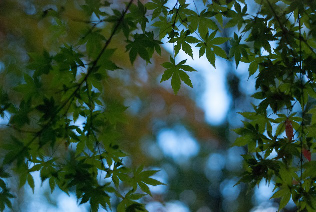

In [6]:
img = PIL.Image.open("images/momiji.jpg")
img.resize(np.array(img.size)//2)

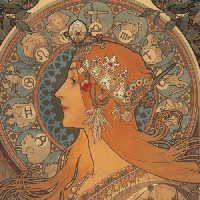

In [7]:
mushaurl = "http://prw.kyodonews.jp/prwfile/release/M100734/201101183960/_prw_fl1_pcmTiRxA.jpg"
img = url2img(mushaurl)
mushaimg = img.crop((100,100,600,600))
mushaimg.resize(np.array((400,400))//2)

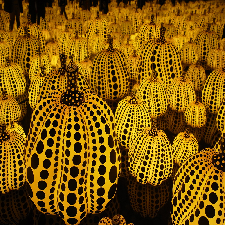

In [14]:
kusama = "http://www.japanjournals.com/images/stories/buraring/2016/05/photo0531_01.jpg"
yayoiimg = url2img(kusama)
yayoiimg.resize(np.array(img.size)//4)

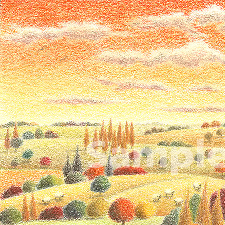

In [9]:
mikako ='https://p1-e6eeae93.imageflux.jp/wgarts/a7a0a6c95cdd9b3c823b.jpeg'
img = url2img(mikako)
mikaimg = img.crop((100,100,600,600))
mikaimg.resize(np.array(img.size)//4)
# サンプル画像だけど特徴は使えるでしょう．

サブディレクトリまたはファイル musha は既に存在します。


    4 3546.70166  = 1577.24109 +1719.20874+ 250.25205  ( -146.53613  -181.59106  -0.44817 (0))

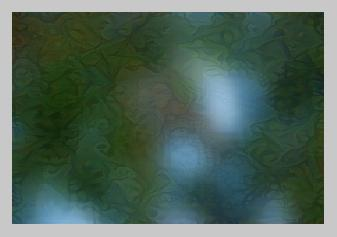

    4 2863.54639  = 1329.89417 +1096.91199+ 436.74014  ( -84.70117  -136.75867  -1.44766 (0)))

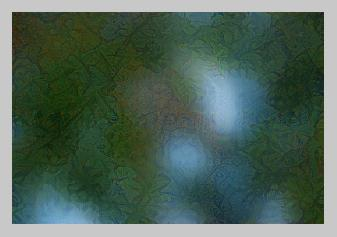

    4 2167.51221  = 1048.28809 +694.74207+ 424.48198  ( -35.36841  -67.58606  -2.31138 (0)))

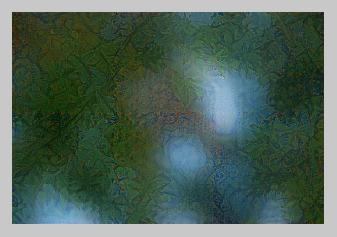

    4 1870.72363  = 877.60077 +582.69739+ 410.42549  ( -28.66907  -36.99945  -2.06353 (0)))

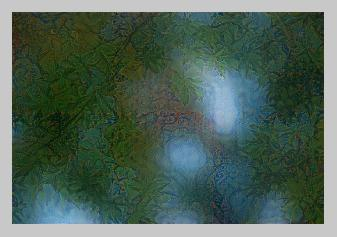

    4 1677.13098  = 770.66241 +512.70685+ 393.76174  ( -38.94647  -6.62659  -2.62156 (0)))

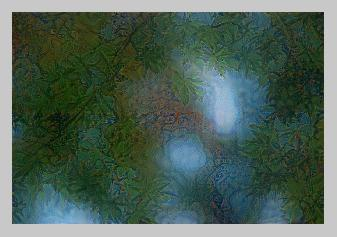

    4 1533.62952  = 703.84320 +451.55701+ 378.22937  ( -19.23688  -17.09961  -2.82532 (0))

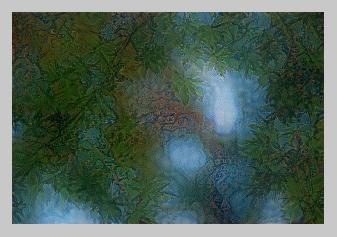

    4 1445.14087  = 657.80627 +424.80353+ 362.53103  ( -32.35724  -6.24075  -2.55315 (0)))

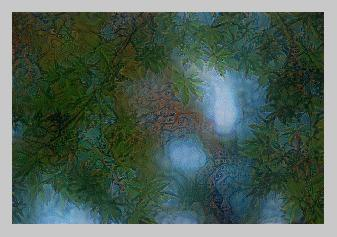

    4 1366.13989  = 622.69690 +396.20230+ 347.24075  ( -21.44885  -6.18436  -2.87690 (0)))

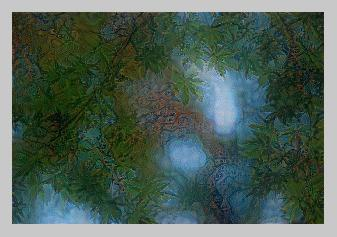

    4 1306.94946  = 589.78802 +384.54852+ 332.61296  ( -28.53271  2.81406  -2.65571 (0))))

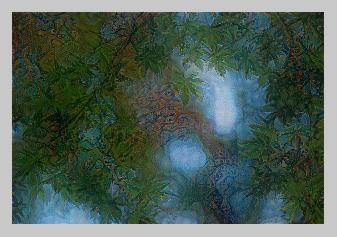

    4 1270.15112  = 577.45178 +371.95599+ 320.74331  ( -19.00006  -7.69327  -1.97322 (0)))

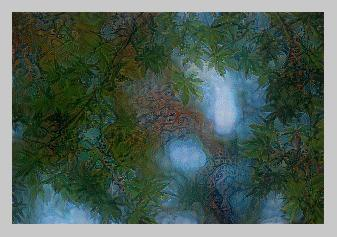

    4 1235.36377  = 565.19824 +360.01495+ 310.15051  ( -25.32550  -2.91190  -1.93699 (0)))

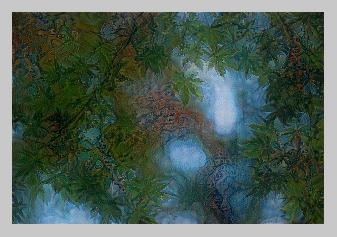

    4 1197.67065  = 541.71509 +357.75085+ 298.20471  ( -27.90546  5.17752  -2.48835 (0))))

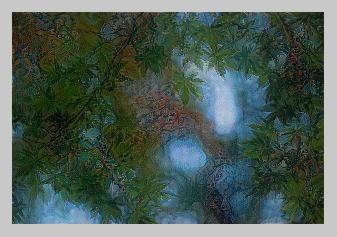

    4 1171.79248  = 533.23212 +349.41626+ 289.14414  ( -20.79504  1.04785  -2.09558 (0))))

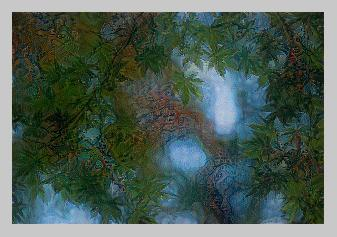

    4 1145.44690  = 520.37128 +346.27106+ 278.80459  ( -24.49738  1.78882  -2.17063 (0))))

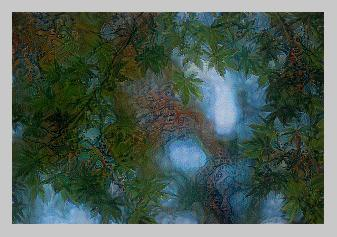

    4 1126.45703  = 515.30566 +340.27026+ 270.88103  ( -18.59393  -7.83136  -1.58633 (0)))

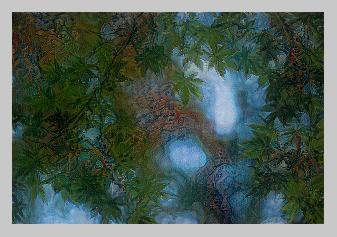

    4 1113.14417  = 510.83603 +338.59036+ 263.71777  ( -33.92697  7.77768  -1.64373 (0))))

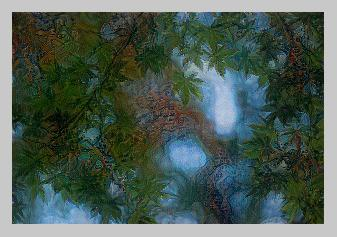

    4 1096.35571  = 497.41592 +342.07794+ 256.86182  ( -28.71524  7.47623  -1.62178 (0))))

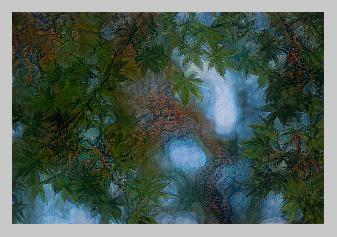

    4 1079.19678  = 499.50519 +328.37704+ 251.31457  ( -15.50018  -7.24780  -1.37783 (0)))

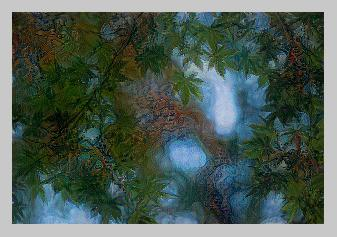

    4 1070.92371  = 487.72226 +337.27747+ 245.92390  ( -34.82993  8.64917  -1.34141 (0))))

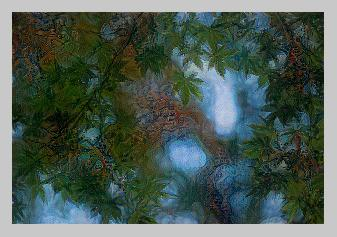

    4 1054.91809  = 491.90012 +322.18005+ 240.83791  ( -3.46008  -13.40106  -1.33960 (0)))

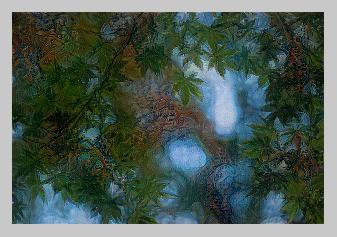

    4 1047.83154  = 484.08609 +326.06833+ 237.67717  ( -10.17285  -16.67044  -0.82568 (0))

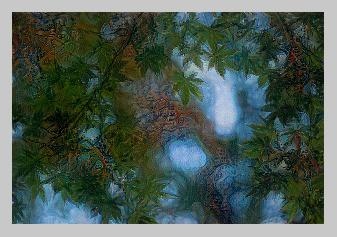

    4 1038.80945  = 483.04532 +323.35110+ 232.41306  ( -12.75226  -7.85239  -1.21819 (0)))

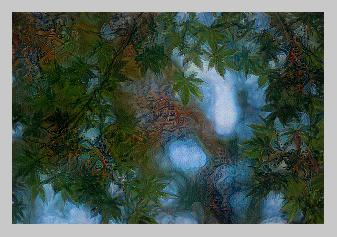

    4 1030.00024  = 475.18335 +325.49866+ 229.31829  ( -19.26642  -4.12500  -0.90747 (0)))

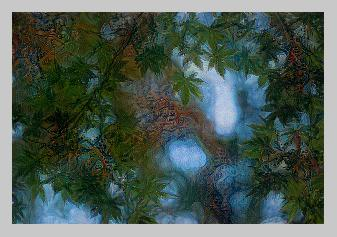

    4 1022.20538  = 477.37375 +319.45969+ 225.37192  ( -6.00888  -9.19638  -1.10669 (0))))

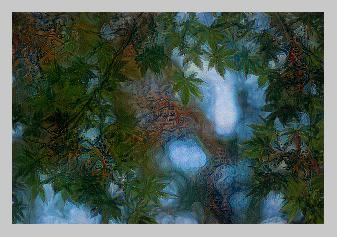

    4 1012.95422  = 464.97290 +324.75079+ 223.23049  ( -19.80582  -10.63266  -0.68369 (0)))

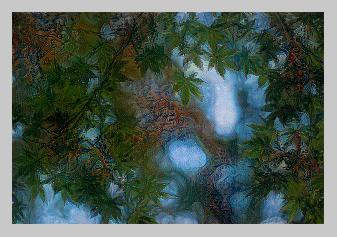

    4 1007.11572  = 469.58383 +317.34424+ 220.18762  ( -12.21255  -9.95096  -0.96836 (0)))

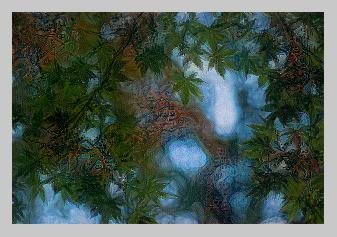

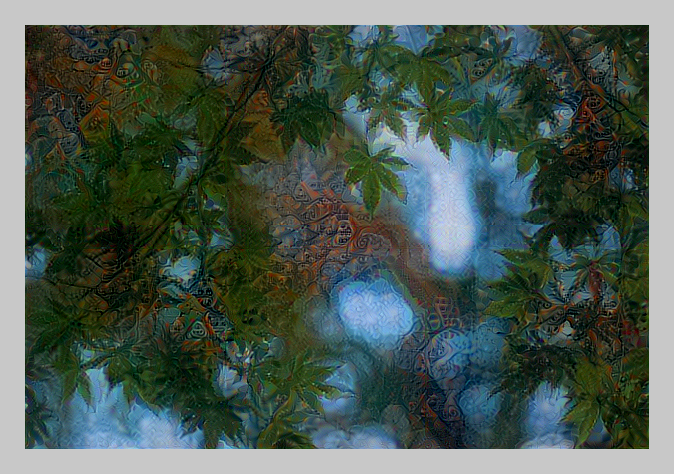

In [10]:
!mkdir musha
lr = np.float32(1.5) # 学習係数
rr1 = np.float32(0.1)
rr2 = np.float32(0.5)
generate3(nn,"images/momiji.jpg",mushaimg,steps=25,itr=5, fn="musha")

### [Imagemagic](https://www.imagemagick.org/script/binary-releases.php)


In [11]:
!"c:\Program Files\ImageMagick-7.0.7-Q16\magick.exe" -delay 12 -loop 0 -resize 300x musha/*.png momiji1.gif

magick.exe: no images found for operation `-resize' at CLI arg 5 @ error/operation.c/CLIOption/5263.


サブディレクトリまたはファイル kusama は既に存在します。


    4 17734.15234  = 1607.33289 +15648.68164+ 478.13965  ( -115.76343  -291.04688  -4.01636 (0))

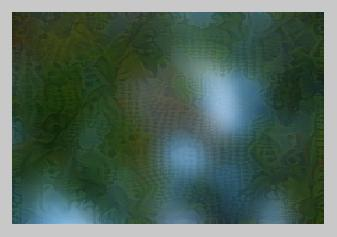

    4 15813.61914  = 1730.86609 +13230.68262+ 852.07002  ( 11.93616  -700.29688  0.15752 (0))))))

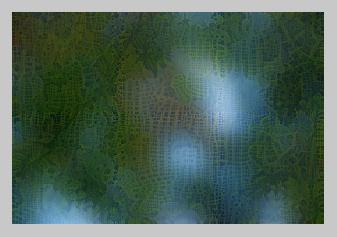

    4 11369.92285  = 2094.93555 +8381.45996+ 893.52705  ( 52.53772  -769.93555  8.25586 (0))))

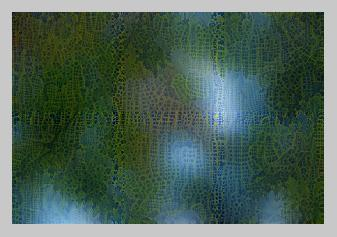

    4 8045.04199  = 2398.44971 +4681.06494+ 965.52754  ( 22.09692  -472.22656  11.45498 (0)))

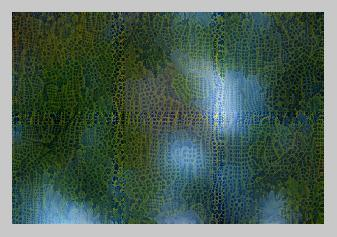

    4 6493.36475  = 2449.63477 +3024.07568+ 1019.65429  ( -12.10645  -212.16284  7.37861 (0))

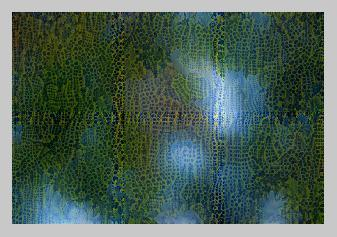

    4 5715.77979  = 2382.75415 +2293.53516+ 1039.49082  ( -18.05908  -119.43408  3.51641 (0)))

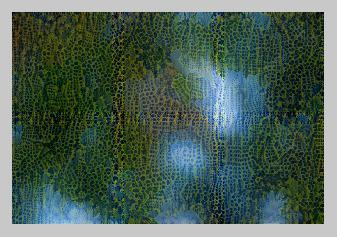

    4 5240.37988  = 2302.06519 +1894.36707+ 1043.94765  ( -26.34424  -70.64661  1.91855 (0))))

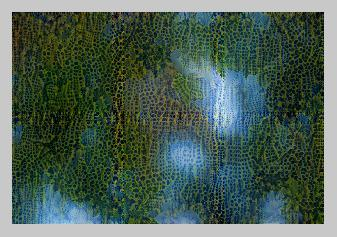

    4 4904.57764  = 2228.05664 +1637.69128+ 1038.82939  ( -19.62354  -54.22888  1.03994 (0))))

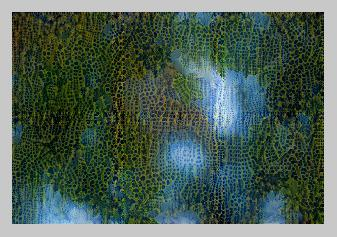

    4 4666.95215  = 2157.74243 +1479.54602+ 1029.66338  ( -16.19189  -46.70337  1.36816 (0)))

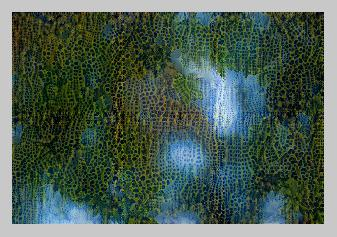

    4 4475.72607  = 2102.27368 +1355.53113+ 1017.92138  ( -11.88257  -33.63257  0.14492 (0)))

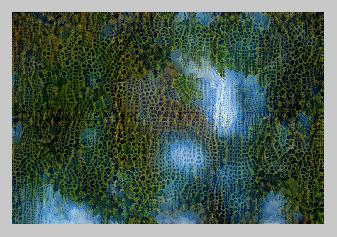

    4 4340.84570  = 2058.72144 +1279.59058+ 1002.53369  ( -12.12769  -53.32825  1.22500 (0))))

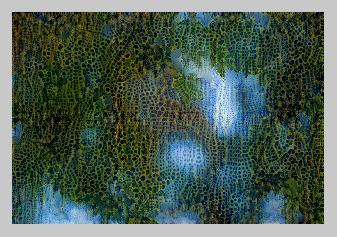

    4 4205.48779  = 2003.48230 +1215.38098+ 986.62431  ( -32.98584  -21.11108  -5.32539 (0)))

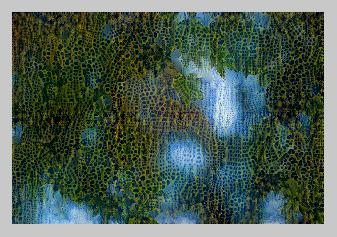

    4 4116.84131  = 1982.84265 +1161.09827+ 972.90019  ( -14.20459  -41.27307  0.93008 (0))))

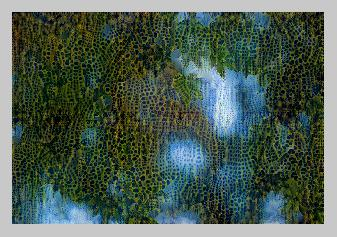

    4 4023.70801  = 1955.32166 +1108.36560+ 960.02060  ( 2.46191  -39.97852  -1.81836 (0)))))

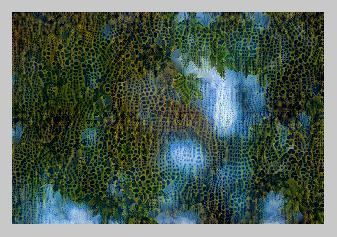

    4 3955.08081  = 1918.99353 +1090.38977+ 945.69756  ( -4.99084  -49.11035  1.94941 (0))))))

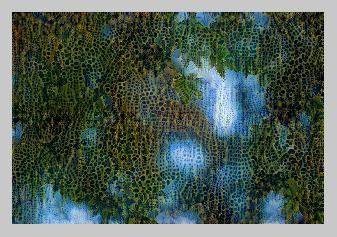

    4 3892.05688  = 1876.41333 +1081.05225+ 934.59121  ( -34.05017  6.11841  -3.22881 (0))))

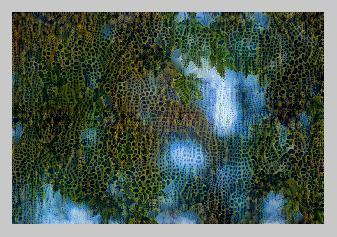

    4 3837.83228  = 1870.30566 +1043.05920+ 924.46748  ( -10.59265  -41.26550  2.00713 (0))))

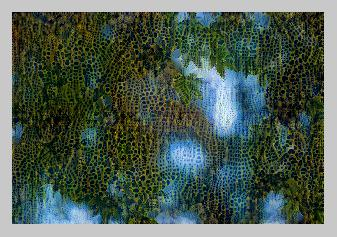

    4 3783.47144  = 1855.17969 +1010.05713+ 918.23457  ( -5.00903  -31.77893  -1.24434 (0))))

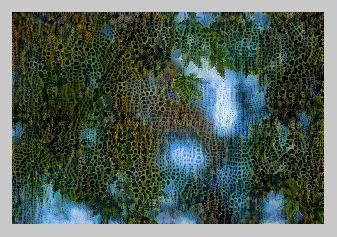

    4 3741.05859  = 1829.05701 +1004.01526+ 907.98623  ( -1.50415  -51.42786  2.48525 (0))))

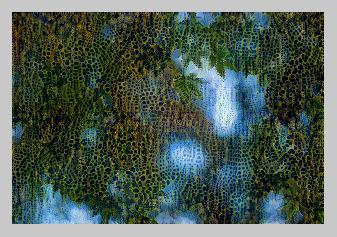

    4 3479.84497  = 1568.52014 +1009.37402+ 901.95097  ( -0.53638  -19.40405  0.99004 (0))))

In [ ]:
!mkdir kusama
lr = np.float32(1.5) # 学習係数
rr1 = np.float32(0.1)
rr2 = np.float32(0.1)
generate3(nn,"images/momiji.jpg",yayoiimg,steps=25,itr=5, fn="kusama")

# まず基本
参照原画に似せる項のみ。当然ながらただちに原画そのものになる。ボケてるのは、ぼかして使っているから。

# Musha

In [ ]:
!mkdir ex8
lr = np.float32(10.0) # 学習係数
rr1 = np.float32(0.01)
rr2 = np.float32(0.05)
rr3 = np.float32(0.0)
img = generate3(nn,"images/momiji.jpg","images/Mucha.png",steps=5,itr=5, fn="ex8")

In [ ]:
!mkdir ex8
lr = np.float32(10.0) # 学習係数
rr1 = np.float32(0.01)
rr2 = np.float32(0.05)
rr3 = np.float32(0.0)
img = generate3(nn,"images/momiji.jpg","images/Mucha.png",steps=5,itr=5, fn="ex8")

In [ ]:
!mkdir ex8
lr = np.float32(1.0) # 学習係数
rr1 = np.float32(0.01)
rr2 = np.float32(0.05)
rr3 = np.float32(0.0)
img = generate3(nn,"images/momiji.jpg","images/kusama.png",steps=5,itr=5, fn="ex10")

In [ ]:
!mkdir ex8
lr = np.float32(10.0) # 学習係数
rr1 = np.float32(0.01)
rr2 = np.float32(0.05)
rr3 = np.float32(0.5)
img = generate3(nn,"images/momiji.jpg","images/kusama.png",steps=5,itr=5, fn="ex10")

In [ ]:
!mkdir ex12
lr = np.float32(3.0) # 学習係数
rr1 = np.float32(0.01)
rr2 = np.float32(0.05)
rr3 = np.float32(0.5)
img = generate3(nn,"images/momiji.jpg","images/mstyle.png",steps=20,itr=5, fn="ex12")

In [ ]:
!mkdir ex13
lr = np.float32(1.0) # 学習係数
rr1 = np.float32(0.05)
rr2 = np.float32(0.15)
rr3 = np.float32(0.2)
img = generate3(nn,"images/momiji.jpg","images/mstyle.png",steps=20,itr=5, fn="ex13")

In [ ]:
!mkdir ex12
lr = np.float32(2000.0) # 学習係数
rr1 = np.float32(0.02)
rr2 = np.float32(0.03)
generate(nn,"images/himawari.png",msurl,crop=3,itr=50, fn="ex12")

In [ ]:
!convert -delay 12 -loop 0 -resize 300x tes/*.png tes.gif

つなぎ目が目立たないようにするために，単純に224ｘ224で区切るのではなく，隣接するブロック同士に重なりのエリアを設け，重なり部分は先行して処理したブロックの処理結果で固定化することにする．

### 実験

重なりを24ピクセルとして試してみる．


In [ ]:
!mkdir ex4
lr = np.float32(10.0) # 学習係数
rr1 = np.float32(0.00)
rr2 = np.float32(1)
generate(nn,"images/himawari.png",msurl,itr=30, fn="ex4", interval=30)

In [ ]:
!mkdir ex12
lr = np.float32(10.0) # 学習係数
rr1 = np.float32(0.01)
rr2 = np.float32(0.05)
generate2(nn,"images/Quebec.jpg","images/Mucha.png",tlsteps=5,itr=5, fn="ex12",interval=5)

In [ ]:
# !mkdir ex13
lr = np.float32(10.0) # 学習係数
rr1 = np.float32(0.01)
rr2 = np.float32(0.05)
rr3 = np.float32(0.01)
generate2(nn,"images/Quebec.jpg","images/Mucha.png",tlsteps=5,itr=5, fn="ex13")

In [ ]:
!mkdir ex14
lr = np.float32(10.0) # 学習係数
rr1 = np.float32(0.01)
rr2 = np.float32(0.05)
rr3 = np.float32(0.01)
generate2(nn,"images/Quebec.jpg","images/Mucha.png",tlsteps=5,itr=5, fn="ex14")

In [ ]:
!mkdir ex16
lr = np.float32(10.0) # 学習係数
rr1 = np.float32(0.01)
rr2 = np.float32(0.05)
rr3 = np.float32(0.5)
generate2(nn,"images/Quebec.jpg","images/Mucha.png",tlsteps=5,itr=5, fn="ex16")

In [ ]:
h,steps=1,0
topkeep=True if h > 0 and steps == 0 else False

In [ ]:
topkeep